#  YOLOv8xتشخیص تومور مغزی با

## کتابخانه ها

In [ ]:
!pip install ultralytics albumentations tqdm gdown -q

from ultralytics import YOLO
import os
import shutil
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import albumentations as A
import pickle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 973.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.1/367.1 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 MB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 28.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.8/307.8 kB 18.9 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quic

## مرحله اول: دریافت دیتاست از لینک مشخص‌شده

In [ ]:
# مسیرها
dataset_url = "https://github.com/ultralytics/assets/releases/download/v0.0.0/brain-tumor.zip"
dataset_zip = "brain-tumor.zip"
dataset_dir = "/content/brain-tumor"
preprocessed_file = "/content/preprocessed_data.pkl"
yaml_path = "/content/brain_tumor.yaml"
checkpoint_dir = "/content/brain_tumor_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

# اگر دیتاست قبلاً دانلود نشده باشد، آن را دریافت و استخراج کن
if not os.path.exists(dataset_dir):
    os.system(f"wget {dataset_url} -O {dataset_zip}")
    shutil.unpack_archive(dataset_zip, "/content")
    print("✅ دیتاست با موفقیت دانلود و استخراج شد")
else:
    print("ℹ️ دیتاست قبلاً وجود داشته است")
# 🔍 بررسی ساختار فایل‌ها بعد از استخراج
print("\n📁 پوشه‌های موجود در /content:")
print(os.listdir("/content"))
if os.path.exists(dataset_dir):
    print("\n📁 محتوای داخل /content/brain-tumor:")
    print(os.listdir(dataset_dir))

✅ دیتاست با موفقیت دانلود و استخراج شد

📁 پوشه‌های موجود در /content:
['.config', 'brain-tumor.zip', 'LICENSE.txt', 'data.yaml', 'brain_tumor.yaml', 'valid', 'brain_tumor_checkpoints', 'train', 'yolov8x.pt', 'sample_data']


## مرحله دوم: پیش‌پردازش داده‌ها (ذخیره نام تصاویر برای صرفه‌جویی)


In [ ]:
def preprocess_data():
    if not os.path.exists(preprocessed_file):
        input_path = "/content/train/images"
        if not os.path.exists(input_path):
            raise FileNotFoundError(f"❌ مسیر تصاویر '{input_path}' یافت نشد!")
        file_list = os.listdir(input_path)
        with open(preprocessed_file, "wb") as f:
            pickle.dump(file_list, f)
        print("✅ پیش‌پردازش انجام شد و داده‌ها ذخیره شدند")
    else:
        with open(preprocessed_file, "rb") as f:
            file_list = pickle.load(f)
        print("ℹ️ داده‌های پیش‌پردازش شده بارگذاری شدند")
    return file_list

## مرحله سوم: ایجاد فایل YAML


In [ ]:
yaml_text = """
path: /content
train: train
val: valid
test: valid
names:
  0: tumor
"""
with open(yaml_path, "w") as f:
    f.write(yaml_text)

##  مرحله چهارم: آموزش مدل با قابلیت Resume و EarlyStopping


In [ ]:
last_ckpt = os.path.join(checkpoint_dir, "yolov8_brain_tumor_preprocessed/weights/last.pt")
model_path = last_ckpt if os.path.exists(last_ckpt) else "yolov8x.pt"
model = YOLO(model_path)

file_list = preprocess_data()

model.train(
    data=yaml_path,
    epochs=150,
    imgsz=640,
    batch=16,
    lr0=0.001,
    weight_decay=0.0005,
    patience=15,
    save=True,
    save_period=20,
    resume=os.path.exists(last_ckpt),
    project=checkpoint_dir,
    name="yolov8_brain_tumor_preprocessed"
)

✅ پیش‌پردازش انجام شد و داده‌ها ذخیره شدند
Ultralytics 8.3.143 🚀 Python-3.11.12 torch-2.6.0+cpu CPU (Intel Xeon 2.00GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/brain_tumor.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8x.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8_brain_tumor_preprocessed, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, pa

100%|██████████| 755k/755k [00:00<00:00, 13.9MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.conv.Conv             [320, 640, 3, 2]              
  6                  -1  6  13117440  ultralytics.nn.modules.block.C2f             [640, 640, 6, True]           


  7                  -1  1   3687680  ultralytics.nn.modules.conv.Conv             [640, 640, 3, 2]              
  8                  -1  3   6969600  ultralytics.nn.modules.block.C2f             [640, 640, 3, True]           
  9                  -1  1   1025920  ultralytics.nn.modules.block.SPPF            [640, 640, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  3   7379200  ultralytics.nn.modules.block.C2f             [1280, 640, 3]                
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 15                  -1  3   1948800  ultralytics.nn.modules.block.C2f             [960,

train: Scanning /content/train/labels... 878 images, 15 backgrounds, 459 corrupt: 100%|██████████| 893/893 [00:00<00:00, 1416.76it/s]

train: /content/train/images/00054_145.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
train: /content/train/images/00054_164.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
train: /content/train/images/00056_110.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
train: /content/train/images/00056_129.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
train: /content/train/images/00056_147.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
train: /content/train/images/00056_239.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
train: /content/train/images/00056_92.jpg: ignoring corrupt image/label: Label class 1 exceeds dataset cla


val: Scanning /content/valid/labels... 223 images, 0 backgrounds, 81 corrupt: 100%|██████████| 223/223 [00:00<00:00, 1840.83it/s]

val: /content/valid/images/val_1 (1).jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/valid/images/val_1 (100).jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/valid/images/val_1 (102).jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/valid/images/val_1 (104).jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/valid/images/val_1 (105).jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/valid/images/val_1 (106).jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/valid/images/val_1 (107).jpg: ignoring corrupt image/label: Label class 1 exceeds dataset clas

Plotting labels to /content/brain_tumor_checkpoints/yolov8_brain_tumor_preprocessed/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to /content/brain_tumor_checkpoints/yolov8_brain_tumor_preprocessed
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150         0G      1.321      3.026      1.372          2        640: 100%|██████████| 28/28 [10:05<00:00, 21.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:00<00:00, 12.04s/it]

                   all        142        154     0.0465      0.344     0.0379     0.0203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150         0G      1.676      3.494      1.654          6        640: 100%|██████████| 28/28 [09:50<00:00, 21.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:02<00:00, 12.46s/it]

                   all        142        154          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150         0G      1.966      2.767      1.956          1        640: 100%|██████████| 28/28 [09:49<00:00, 21.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:59<00:00, 11.98s/it]

                   all        142        154          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150         0G      1.808       2.17      1.853          2        640: 100%|██████████| 28/28 [09:53<00:00, 21.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:02<00:00, 12.40s/it]

                   all        142        154   0.000235     0.0649   0.000157   5.82e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150         0G      1.783      1.912      1.794          1        640: 100%|██████████| 28/28 [09:52<00:00, 21.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:03<00:00, 12.64s/it]

                   all        142        154   0.000399       0.11    0.00024   7.75e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150         0G      1.734      1.604      1.735          2        640: 100%|██████████| 28/28 [09:59<00:00, 21.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:04<00:00, 12.96s/it]

                   all        142        154   0.000493      0.136   0.000327   8.02e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150         0G      1.578      1.527      1.642          2        640: 100%|██████████| 28/28 [10:02<00:00, 21.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:03<00:00, 12.68s/it]

                   all        142        154   6.98e-05      0.013    3.6e-05    7.2e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150         0G      1.456       1.41      1.528          4        640: 100%|██████████| 28/28 [10:04<00:00, 21.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:02<00:00, 12.51s/it]

                   all        142        154      0.942     0.0325     0.0357     0.0266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150         0G      1.328      1.274      1.468          1        640: 100%|██████████| 28/28 [10:03<00:00, 21.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:01<00:00, 12.24s/it]

                   all        142        154      0.765       0.11      0.116     0.0644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150         0G      1.382      1.295      1.467          1        640: 100%|██████████| 28/28 [10:06<00:00, 21.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:04<00:00, 12.90s/it]

                   all        142        154      0.528     0.0653      0.101     0.0404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150         0G      1.339      1.247      1.477          4        640: 100%|██████████| 28/28 [10:11<00:00, 21.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:04<00:00, 12.96s/it]

                   all        142        154       0.69      0.266      0.322      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150         0G      1.322      1.092      1.479          4        640: 100%|██████████| 28/28 [10:13<00:00, 21.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:03<00:00, 12.66s/it]

                   all        142        154      0.845       0.61      0.734      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150         0G      1.274      1.061      1.392          6        640: 100%|██████████| 28/28 [10:16<00:00, 22.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:05<00:00, 13.12s/it]

                   all        142        154      0.668     0.0195     0.0294     0.0199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150         0G      1.298      1.063      1.407          3        640: 100%|██████████| 28/28 [10:26<00:00, 22.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:00<00:00, 12.13s/it]

                   all        142        154      0.818      0.525      0.606      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150         0G      1.245      1.083       1.36          4        640: 100%|██████████| 28/28 [10:23<00:00, 22.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:03<00:00, 12.61s/it]

                   all        142        154      0.812      0.805      0.863      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150         0G      1.235     0.9724      1.364          5        640: 100%|██████████| 28/28 [10:21<00:00, 22.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:01<00:00, 12.36s/it]

                   all        142        154      0.793      0.825       0.87      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150         0G      1.308      1.019      1.421          3        640: 100%|██████████| 28/28 [10:17<00:00, 22.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:02<00:00, 12.43s/it]

                   all        142        154      0.734      0.644      0.712      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150         0G      1.296      1.044      1.469          4        640: 100%|██████████| 28/28 [10:10<00:00, 21.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:00<00:00, 12.09s/it]

                   all        142        154      0.785      0.786      0.836      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150         0G      1.253       1.01      1.388          2        640: 100%|██████████| 28/28 [10:06<00:00, 21.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:00<00:00, 12.17s/it]

                   all        142        154      0.739      0.771      0.807      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150         0G      1.171     0.9402      1.313          2        640: 100%|██████████| 28/28 [10:03<00:00, 21.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:00<00:00, 12.10s/it]

                   all        142        154      0.865      0.793      0.872      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150         0G      1.156     0.9244       1.31          3        640: 100%|██████████| 28/28 [09:52<00:00, 21.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:00<00:00, 12.03s/it]

                   all        142        154      0.883      0.832      0.913      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150         0G       1.17     0.8606       1.35          1        640: 100%|██████████| 28/28 [09:56<00:00, 21.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:00<00:00, 12.00s/it]

                   all        142        154      0.774      0.712      0.763      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150         0G      1.129     0.8679      1.306          5        640: 100%|██████████| 28/28 [09:59<00:00, 21.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:02<00:00, 12.42s/it]

                   all        142        154      0.814      0.688      0.774      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150         0G       1.16     0.9107      1.323          4        640: 100%|██████████| 28/28 [10:08<00:00, 21.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:02<00:00, 12.51s/it]

                   all        142        154      0.782      0.552      0.671      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150         0G      1.163     0.9149      1.336          2        640: 100%|██████████| 28/28 [10:08<00:00, 21.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:03<00:00, 12.77s/it]

                   all        142        154      0.889      0.727      0.857      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150         0G      1.077     0.8776       1.24          2        640: 100%|██████████| 28/28 [10:04<00:00, 21.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:03<00:00, 12.67s/it]

                   all        142        154      0.768      0.519       0.63      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150         0G      1.152     0.8679      1.318          3        640: 100%|██████████| 28/28 [10:11<00:00, 21.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:03<00:00, 12.70s/it]

                   all        142        154      0.806      0.786      0.857      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150         0G      1.066     0.7941      1.261          5        640: 100%|██████████| 28/28 [10:23<00:00, 22.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:04<00:00, 12.81s/it]

                   all        142        154      0.868      0.727      0.815      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150         0G      1.023     0.7417      1.236          3        640: 100%|██████████| 28/28 [10:20<00:00, 22.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:06<00:00, 13.30s/it]

                   all        142        154      0.818       0.87      0.912      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150         0G      1.075     0.8031      1.284          2        640: 100%|██████████| 28/28 [10:24<00:00, 22.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:04<00:00, 12.87s/it]

                   all        142        154      0.806      0.727      0.824      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150         0G       1.01     0.7588      1.221          4        640: 100%|██████████| 28/28 [10:30<00:00, 22.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:06<00:00, 13.24s/it]

                   all        142        154      0.843      0.766      0.864      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150         0G      1.072     0.7671       1.26          4        640: 100%|██████████| 28/28 [10:26<00:00, 22.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:04<00:00, 12.96s/it]

                   all        142        154      0.867      0.812      0.894       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150         0G      1.052     0.7689      1.254          1        640: 100%|██████████| 28/28 [10:15<00:00, 21.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:03<00:00, 12.65s/it]

                   all        142        154      0.803      0.864        0.9      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150         0G      1.053     0.7537      1.227          5        640: 100%|██████████| 28/28 [10:18<00:00, 22.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:02<00:00, 12.53s/it]

                   all        142        154      0.819      0.708      0.768      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150         0G      1.065     0.7796      1.263          3        640: 100%|██████████| 28/28 [10:23<00:00, 22.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:02<00:00, 12.53s/it]

                   all        142        154      0.865      0.734      0.853      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150         0G      1.083       0.78      1.269          2        640: 100%|██████████| 28/28 [10:27<00:00, 22.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:04<00:00, 12.85s/it]

                   all        142        154      0.823      0.873      0.892       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150         0G      1.049     0.7661      1.242          5        640: 100%|██████████| 28/28 [10:25<00:00, 22.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:04<00:00, 12.84s/it]

                   all        142        154       0.86      0.851      0.902      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150         0G      1.051      0.723      1.269          3        640: 100%|██████████| 28/28 [10:23<00:00, 22.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:03<00:00, 12.61s/it]

                   all        142        154      0.921      0.831      0.931      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150         0G      1.073     0.7585      1.271          2        640: 100%|██████████| 28/28 [10:23<00:00, 22.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:02<00:00, 12.40s/it]

                   all        142        154      0.884      0.721      0.841      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150         0G      1.056     0.7061      1.226          6        640: 100%|██████████| 28/28 [10:19<00:00, 22.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:03<00:00, 12.72s/it]

                   all        142        154      0.872        0.8      0.888      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150         0G      1.051     0.7145      1.233          2        640: 100%|██████████| 28/28 [10:24<00:00, 22.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:58<00:00, 11.70s/it]

                   all        142        154      0.838      0.799       0.89       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150         0G      1.047     0.7334      1.224          3        640: 100%|██████████| 28/28 [10:18<00:00, 22.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:00<00:00, 12.02s/it]

                   all        142        154      0.881       0.82      0.902      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150         0G      1.067     0.7378      1.259          3        640: 100%|██████████| 28/28 [10:13<00:00, 21.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:58<00:00, 11.79s/it]

                   all        142        154      0.902      0.844      0.926      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150         0G      1.079     0.8303      1.278          2        640: 100%|██████████| 28/28 [10:08<00:00, 21.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:58<00:00, 11.66s/it]

                   all        142        154      0.846      0.785      0.882      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150         0G     0.9928     0.6608      1.198          4        640: 100%|██████████| 28/28 [10:14<00:00, 21.96s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:02<00:00, 12.42s/it]

                   all        142        154      0.897      0.852      0.925       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150         0G      1.026     0.6888      1.232          2        640: 100%|██████████| 28/28 [10:13<00:00, 21.92s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:57<00:00, 11.60s/it]

                   all        142        154       0.87      0.779       0.87      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150         0G     0.9974      0.694      1.181          8        640: 100%|██████████| 28/28 [10:10<00:00, 21.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:58<00:00, 11.74s/it]

                   all        142        154      0.881      0.825      0.912      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150         0G     0.9807     0.6513      1.195          5        640: 100%|██████████| 28/28 [10:09<00:00, 21.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:02<00:00, 12.58s/it]

                   all        142        154      0.816      0.896      0.925       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150         0G     0.9929      0.639      1.196          2        640: 100%|██████████| 28/28 [10:05<00:00, 21.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:02<00:00, 12.58s/it]

                   all        142        154       0.91      0.851      0.922      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150         0G     0.9714     0.6188      1.205          2        640: 100%|██████████| 28/28 [10:09<00:00, 21.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:59<00:00, 11.95s/it]

                   all        142        154      0.885      0.831      0.906      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150         0G     0.9495      0.661      1.187          3        640: 100%|██████████| 28/28 [10:11<00:00, 21.82s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:02<00:00, 12.56s/it]

                   all        142        154       0.85      0.786      0.876      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150         0G     0.9653     0.6548      1.189          6        640: 100%|██████████| 28/28 [10:13<00:00, 21.90s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:03<00:00, 12.61s/it]

                   all        142        154      0.889      0.836      0.924      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150         0G     0.9543     0.6299       1.16          1        640: 100%|██████████| 28/28 [10:08<00:00, 21.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:00<00:00, 12.13s/it]

                   all        142        154      0.881       0.87      0.919      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150         0G      0.941     0.6414       1.17          6        640: 100%|██████████| 28/28 [10:01<00:00, 21.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:02<00:00, 12.59s/it]

                   all        142        154      0.902      0.832      0.908      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150         0G      0.922     0.6026      1.155          4        640: 100%|██████████| 28/28 [10:07<00:00, 21.70s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:03<00:00, 12.67s/it]

                   all        142        154      0.846       0.87      0.916      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150         0G     0.9627     0.6406      1.205          3        640: 100%|██████████| 28/28 [10:07<00:00, 21.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:03<00:00, 12.72s/it]

                   all        142        154      0.888      0.775      0.884      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150         0G     0.9192     0.6403      1.176          1        640: 100%|██████████| 28/28 [10:09<00:00, 21.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:03<00:00, 12.72s/it]

                   all        142        154      0.887      0.825      0.911      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150         0G     0.9691      0.628      1.213          6        640: 100%|██████████| 28/28 [10:05<00:00, 21.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:03<00:00, 12.75s/it]

                   all        142        154      0.854      0.799      0.898      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150         0G     0.8902     0.5914       1.16          3        640: 100%|██████████| 28/28 [10:13<00:00, 21.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:03<00:00, 12.77s/it]

                   all        142        154      0.832      0.806      0.882      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150         0G     0.9469     0.6372      1.198          2        640: 100%|██████████| 28/28 [10:19<00:00, 22.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:04<00:00, 12.92s/it]

                   all        142        154      0.858      0.826      0.911      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150         0G     0.8829     0.5941      1.144          1        640: 100%|██████████| 28/28 [10:25<00:00, 22.35s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:07<00:00, 13.41s/it]

                   all        142        154      0.854      0.851      0.916      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150         0G     0.8731     0.5815      1.137          5        640: 100%|██████████| 28/28 [10:25<00:00, 22.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:04<00:00, 12.93s/it]

                   all        142        154      0.817       0.87      0.907      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150         0G     0.8706     0.6497      1.107          0        640: 100%|██████████| 28/28 [10:29<00:00, 22.50s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:08<00:00, 13.73s/it]

                   all        142        154      0.928      0.831      0.934      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150         0G     0.8717     0.5743      1.124          3        640: 100%|██████████| 28/28 [10:36<00:00, 22.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:08<00:00, 13.72s/it]

                   all        142        154       0.82       0.83      0.888       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150         0G     0.9002     0.5893      1.162          4        640: 100%|██████████| 28/28 [10:36<00:00, 22.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:03<00:00, 12.68s/it]

                   all        142        154      0.896      0.799      0.908      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150         0G     0.9329     0.6014      1.162          5        640: 100%|██████████| 28/28 [10:23<00:00, 22.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:00<00:00, 12.06s/it]

                   all        142        154      0.887      0.868      0.913      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150         0G     0.8877     0.5907      1.139          2        640: 100%|██████████| 28/28 [10:23<00:00, 22.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:03<00:00, 12.74s/it]

                   all        142        154       0.89      0.786      0.889      0.627
EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 52, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



67 epochs completed in 12.614 hours.
Optimizer stripped from /content/brain_tumor_checkpoints/yolov8_brain_tumor_preprocessed/weights/last.pt, 136.7MB
Optimizer stripped from /content/brain_tumor_checkpoints/yolov8_brain_tumor_preprocessed/weights/best.pt, 136.7MB

Validating /content/brain_tumor_checkpoints/yolov8_brain_tumor_preprocessed/weights/best.pt...
Ultralytics 8.3.143 🚀 Python-3.11.12 torch-2.6.0+cpu CPU (Intel Xeon 2.00GHz)
Model summary (fused): 112 layers, 68,124,531 parameters, 0 gradients, 257.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:03<00:00, 12.73s/it]


                   all        142        154      0.889      0.829      0.925      0.686
Speed: 0.5ms preprocess, 441.9ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to /content/brain_tumor_checkpoints/yolov8_brain_tumor_preprocessed


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7aa9beba7d50>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

### مرحله پنجم: ارزیابی روی داده‌های تست و رسم نمودار


Ultralytics 8.3.143 🚀 Python-3.11.12 torch-2.6.0+cpu CPU (Intel Xeon 2.00GHz)
Model summary (fused): 112 layers, 68,124,531 parameters, 0 gradients, 257.4 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 202.7±79.0 MB/s, size: 4.3 KB)


val: Scanning /content/valid/labels.cache... 223 images, 0 backgrounds, 81 corrupt: 100%|██████████| 223/223 [00:00<?, ?it/s]

val: /content/valid/images/val_1 (1).jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/valid/images/val_1 (100).jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/valid/images/val_1 (102).jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/valid/images/val_1 (104).jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/valid/images/val_1 (105).jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/valid/images/val_1 (106).jpg: ignoring corrupt image/label: Label class 1 exceeds dataset class count 1. Possible class labels are 0-0
val: /content/valid/images/val_1 (107).jpg: ignoring corrupt image/label: Label class 1 exceeds dataset clas


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:55<00:00,  6.14s/it]


                   all        142        154      0.889      0.829      0.925      0.686
Speed: 0.4ms preprocess, 383.5ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/detect/val5

📈 نتایج ارزیابی مدل روی داده‌های تست:
Precision: 0.8886
Recall: 0.8291
mAP@0.5: 0.9245
mAP@0.5:0.95: 0.6863


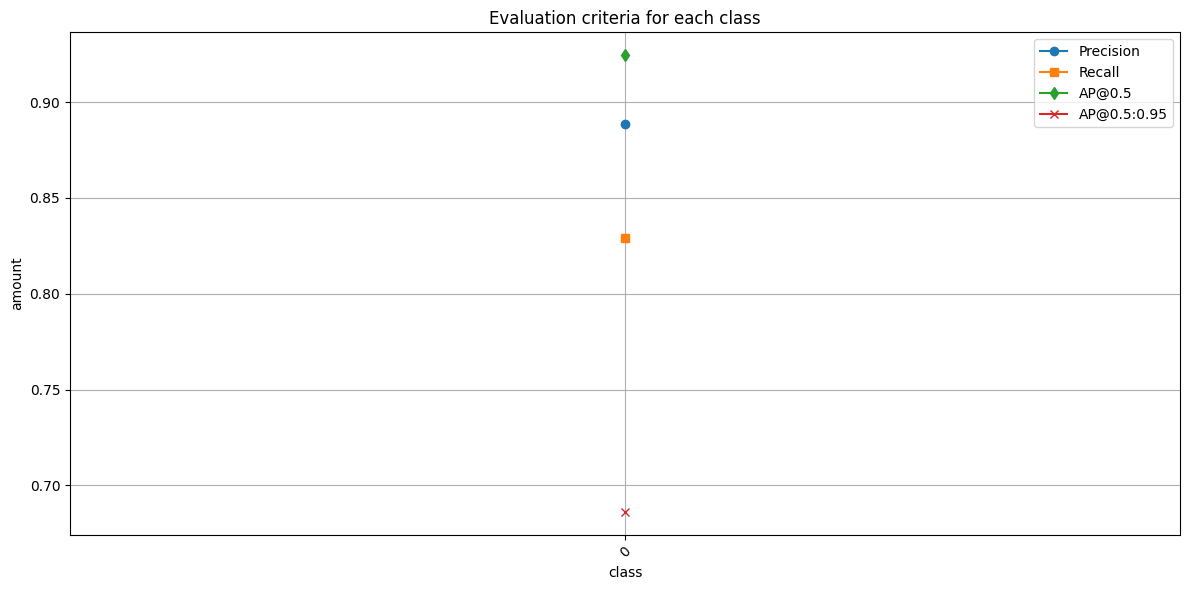

In [ ]:
model = YOLO(f"{checkpoint_dir}/yolov8_brain_tumor_preprocessed/weights/best.pt")
results = model.val(data=yaml_path, split='test')

print(f"\n📈 نتایج ارزیابی مدل روی داده‌های تست:")
print(f"Precision: {results.box.mp:.4f}")
print(f"Recall: {results.box.mr:.4f}")
print(f"mAP@0.5: {results.box.map50:.4f}")
print(f"mAP@0.5:0.95: {results.box.map:.4f}")

classes = list(results.names)
x = range(len(classes))
plt.figure(figsize=(12,6))
plt.plot(x, results.box.p, 'o-', label='Precision')
plt.plot(x, results.box.r, 's-', label='Recall')
plt.plot(x, results.box.ap50, 'd-', label='AP@0.5')
plt.plot(x, results.box.ap, 'x-', label='AP@0.5:0.95')
plt.xticks(x, classes, rotation=45)
plt.title("Evaluation criteria for each class")
plt.xlabel("class")
plt.ylabel("amount")
plt.legend()
plt.grid(True)
plt.tight_layout()

##  مرحله ششم: پیش‌بینی روی چند تصویر تست



image 1/1 /content/valid/images/val_1 (176).jpg: 640x640 1 tumor, 461.4ms
Speed: 4.0ms preprocess, 461.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)


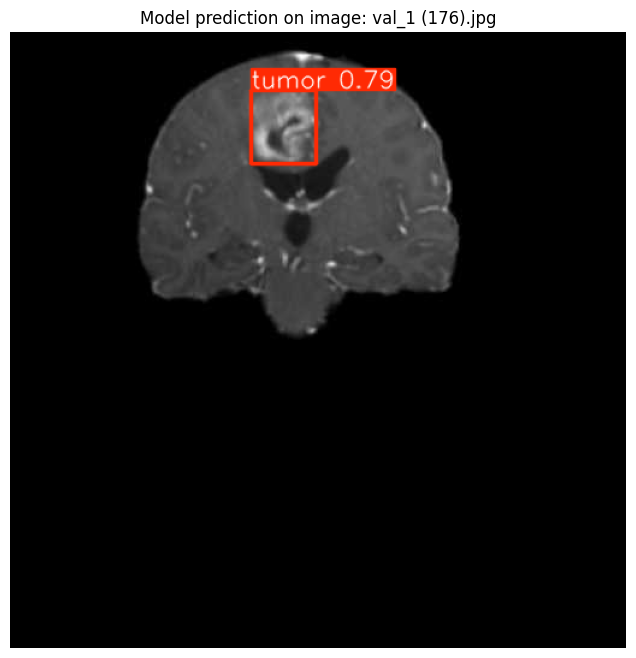


image 1/1 /content/valid/images/val_1 (181).jpg: 640x640 1 tumor, 460.3ms
Speed: 3.2ms preprocess, 460.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


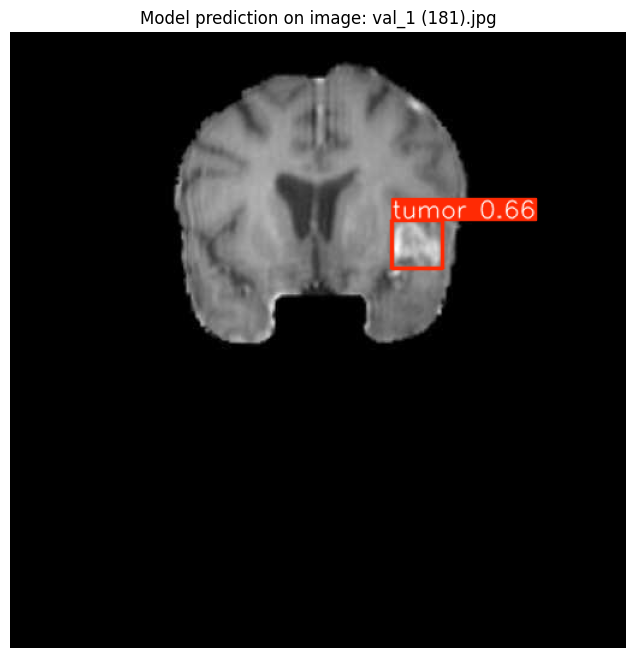


image 1/1 /content/valid/images/val_1 (118).jpg: 640x640 2 tumors, 465.7ms
Speed: 3.6ms preprocess, 465.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


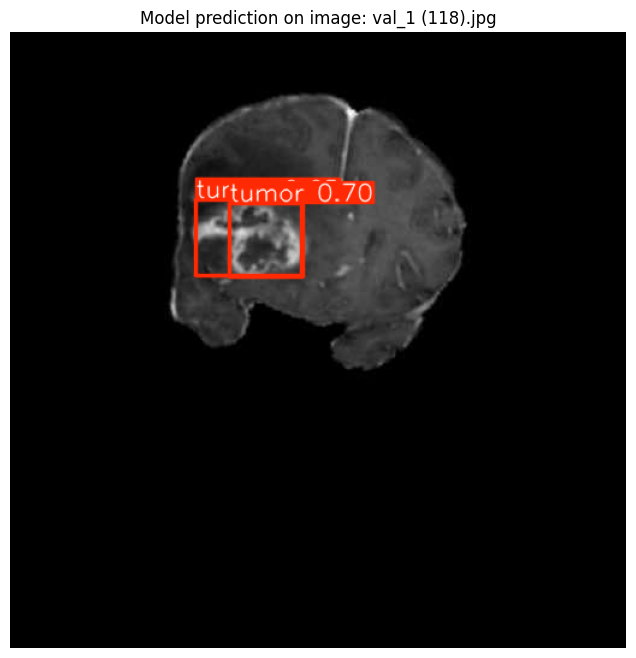


image 1/1 /content/valid/images/val_1 (7).jpg: 640x640 2 tumors, 471.6ms
Speed: 3.5ms preprocess, 471.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


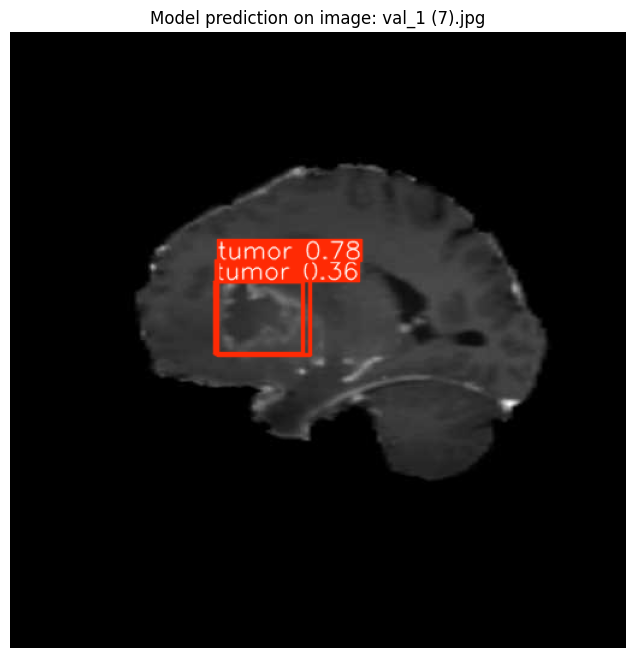


image 1/1 /content/valid/images/val_1 (53).jpg: 640x640 1 tumor, 463.6ms
Speed: 3.0ms preprocess, 463.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


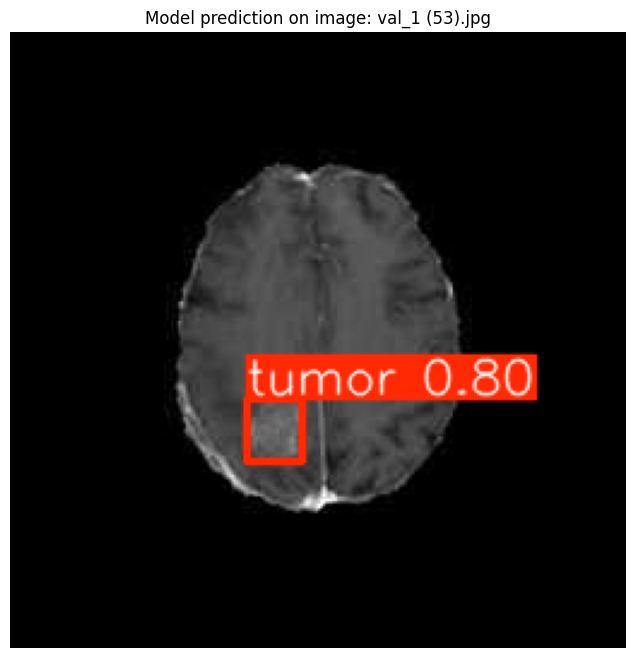

In [ ]:
import cv2

test_img_dir = "/content/valid/images"
test_imgs = os.listdir(test_img_dir)[:5]
for img_name in test_imgs:
    img_path = os.path.join(test_img_dir, img_name)
    preds = model.predict(source=img_path, imgsz=640, conf=0.25)
    annotated_img = preds[0].plot()
    plt.figure(figsize=(8,8))
    plt.imshow(annotated_img)
    plt.title(f"Model prediction on image: {img_name}")
    plt.axis('off')
    plt.show()

🎯 دقت تقریبی مدل:
✅ دقت آموزش (تقریبی): 0.9190
✅ دقت تست: 0.8379


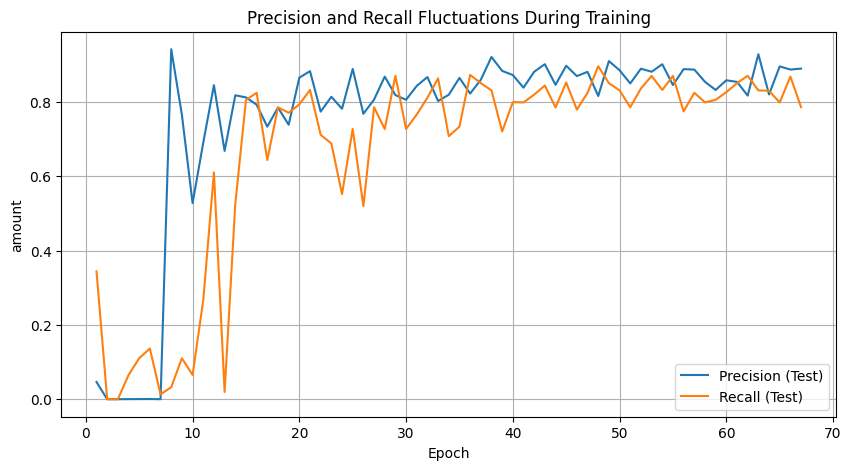

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("/content/brain_tumor_checkpoints/yolov8_brain_tumor_preprocessed/results.csv")


precision_test = df["metrics/precision(B)"].iloc[-1]
recall_test = df["metrics/recall(B)"].iloc[-1]
accuracy_test = (precision_test + recall_test) / 2

precision_train = df["metrics/precision(B)"].max()
recall_train = df["metrics/recall(B)"].max()
accuracy_train = (precision_train + recall_train) / 2

print("🎯 دقت تقریبی مدل:")
print(f"✅ دقت آموزش (تقریبی): {accuracy_train:.4f}")
print(f"✅ دقت تست: {accuracy_test:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(df["epoch"], df["metrics/precision(B)"], label="Precision (Test)")
plt.plot(df["epoch"], df["metrics/recall(B)"], label="Recall (Test)")
plt.title("Precision and Recall Fluctuations During Training")
plt.xlabel("Epoch")
plt.ylabel("amount")
plt.legend()
plt.grid(True)
plt.show()
